In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 13 10:59:32 2018

@author: Rein
"""

import os
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, Normalizer, Imputer
import seaborn as sns; sns.set()
import scipy.sparse as sp
np.random.seed(19)
import random
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
# =============================================================================
def get_hourcoef(datacopy):
  '''
  This is to setup the hourly coef based on hourly mean value and Weekday/Weekend
  '''
#  datacopy.set_index('datetime', drop=True, inplace =True)
#  datacopy.index = pd.DatetimeIndex(datacopy.index)
#  datacopy.plot()
  
  weekly = datacopy.resample('W').sum()
  imp = Imputer(missing_values=0, strategy='mean', axis=0)
  weekly['count'] = imp.fit_transform(weekly['count'].values.reshape(-1,1))
  weekly.plot(style=[':', '--', '-'])
  plt.ylabel('Weekly bicycle count')

  weekend = np.where(datacopy.index.weekday < 5, 'Weekday', 'Weekend')
  by_time = datacopy.groupby([weekend, datacopy.index.hour]).mean()
#  by_time1 = datacopy.groupby([weekend, datacopy.index.hour])['count'].agg([np.mean])
  by_time['hour_coef']= MinMaxScaler().fit_transform(by_time['count'].values.reshape(-1,1))
  by_time.drop(['count'], axis = 1, inplace = True)
  return by_time


In [3]:
# In[]:
def conv_peakhour(df, by_time):
  dfcp = df.copy(deep = True)
  buf = []
  for row in dfcp.itertuples():
    cur_hour = row.Index.hour
    isweekend = 'Weekday' if row.Index.dayofweek < 5 else 'Weekend'
    cur_coef = by_time.loc[isweekend, cur_hour]['hour_coef']
    buf.append(cur_coef)
#  df['hour_coef'] = buf
  return pd.DataFrame(data = buf, index = df.index, columns = ['hour_coef'])


In [4]:
def norm_data(df, cols):
  space = None
  for col in cols:
    if col in df.columns:
      colval = MinMaxScaler().fit_transform(df[col].values.reshape(-1,1))
      if space is None:
        space = colval
      else:
        space = np.hstack((space, colval)) #this is because we have already reshaped colval
        print('continous shape =', space.shape, 'type = ', type(space))
      df.pop(col)
  return pd.DataFrame(data = space, index = df.index, columns = cols)

In [5]:
def enc_data(train, cols):
  train_space = None
  feature_buf = []
  for cc in cols:
    if cc in train.columns:
      try:
          train[cc] = LabelEncoder().fit_transform(train[cc].apply(int))
      except:
          train[cc] = LabelEncoder().fit_transform(train[cc])
      oneenc = OneHotEncoder(sparse = True)
      oneenc.fit(train[cc].values.reshape(-1,1))
      train_a = oneenc.transform(train[cc].values.reshape(-1,1))

      print("{} shape = {}" .format(cc , train_a.shape))
      if train_space is None:
        train_space = train_a
      else:
        train_space = sp.hstack((train_space,train_a))
        
      for i in range(train_a.shape[1]):
        feature_buf.append(cc+str(oneenc.active_features_[i]))

  train_x = pd.DataFrame(data = train_space.toarray(), columns=feature_buf, index=train.index)
  return train_x


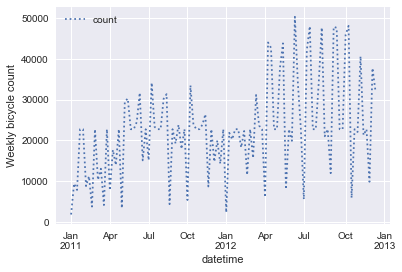

In [6]:
data_folder = os.path.abspath(os.getcwd())
traindata = pd.read_csv(os.path.join(data_folder, "train.csv"))
testdata = pd.read_csv(os.path.join(data_folder, "test.csv"))
res=testdata[['datetime']]
traindata.set_index('datetime', drop=True, inplace =True)
traindata.index = pd.DatetimeIndex(traindata.index)

testdata.set_index('datetime', drop=True, inplace =True)
testdata.index = pd.DatetimeIndex(testdata.index)
train_week = traindata[['workingday', 'holiday']]
test_week = testdata[['workingday', 'holiday']]
train_slice = traindata[['count']]
hour_coef = get_hourcoef(train_slice)

               count
datetime            
2011      143.293212
2012      237.482495


Int64Index([2011, 2012], dtype='int64', name='datetime')

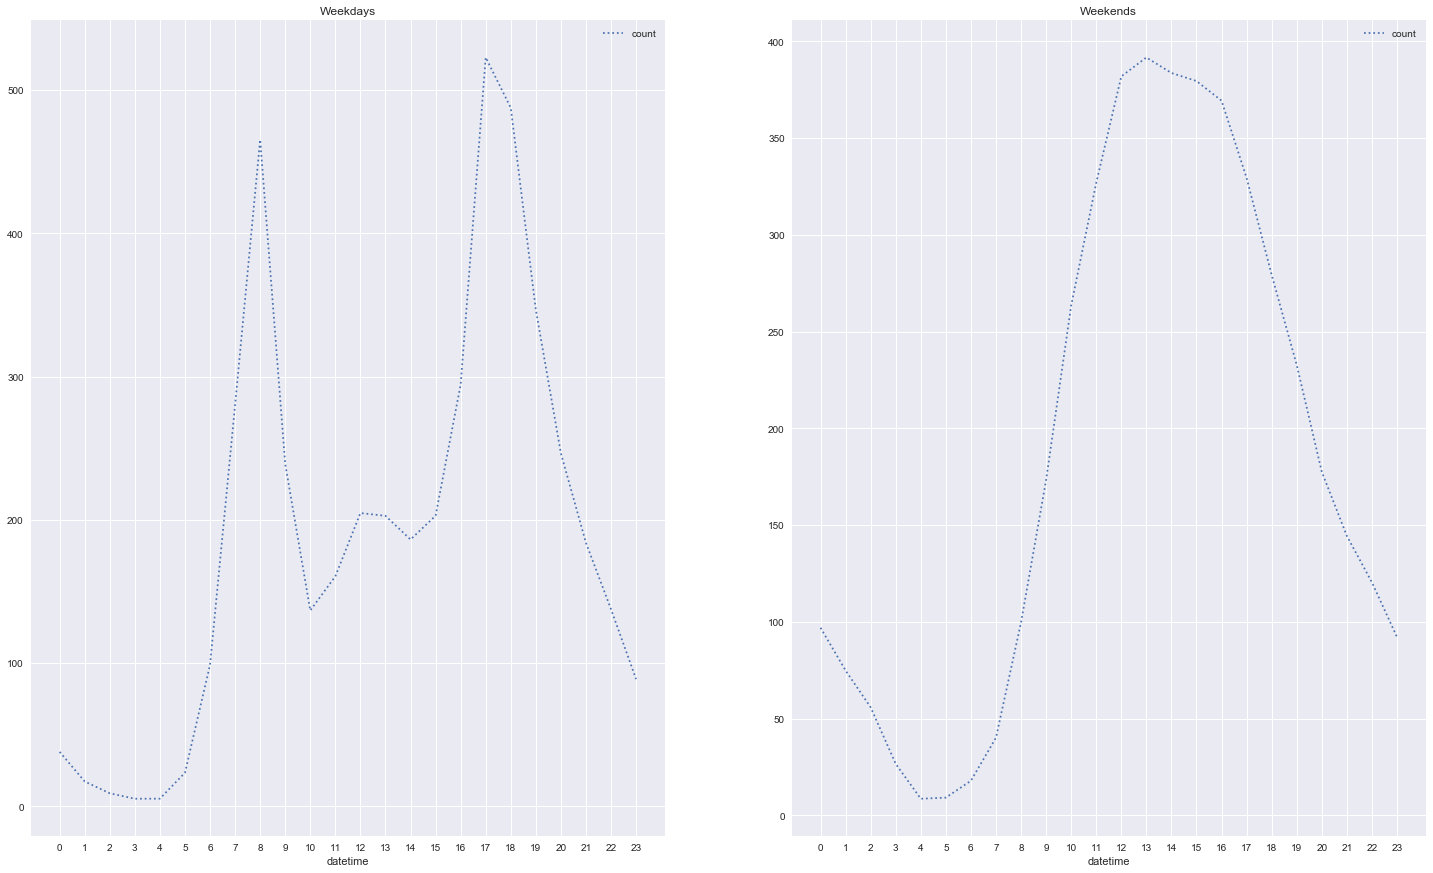

In [7]:
weekend = np.where(train_slice.index.weekday < 5, 'Weekday', 'Weekend')
by_time = train_slice.groupby([weekend, train_slice.index.hour]).mean()
fig, ax = plt.subplots(1, 2, figsize=(25,15))
hourly_ticks = np.arange(24)
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays', xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends', xticks=hourly_ticks, style=[':', '--', '-'])

by_year = train_slice.groupby(train_slice.index.year).mean()
print(by_year)
testdata.index.year.unique()

In [8]:
train_y = traindata.pop('count')
train_x = conv_peakhour(traindata, hour_coef)
test_x = conv_peakhour(testdata, hour_coef)

poplist = ['atemp', 'casual', 'registered']
one_hot_features = ['season', 'weather', 'year']
continue_features = ['windspeed', 'humidity', 'temp']

# remove poplist features
for col in poplist:
    if col in traindata.columns:
        traindata.pop(col)
    if col in testdata.columns:
        testdata.pop(col)

In [9]:
data = pd.concat([traindata, testdata])
data['year'] = data.index.year
data_ohc = enc_data(data, one_hot_features)
data_norm = norm_data(data, continue_features)


season shape = (10886, 4)
weather shape = (10886, 4)
year shape = (10886, 2)
continous shape = (10886, 2) type =  <class 'numpy.ndarray'>
continous shape = (10886, 3) type =  <class 'numpy.ndarray'>


C:\Users\rein9\Anaconda3\envs\tfbase\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
train_ohc = data_ohc.iloc[:traindata.shape[0],:]
test_ohc = data_ohc.iloc[traindata.shape[0]:,:]
train_norm = data_norm.iloc[:traindata.shape[0],:]
test_norm = data_norm.iloc[traindata.shape[0]:,:]

train_x = pd.merge_asof(train_x, train_ohc, left_index = True, right_index = True)
train_x = pd.merge_asof(train_x, train_norm, left_index = True, right_index = True)
train_x = pd.merge_asof(train_x, train_week, left_index = True, right_index = True)

test_x = pd.merge_asof(test_x, test_ohc, left_index = True, right_index = True)
test_x = pd.merge_asof(test_x, test_norm, left_index = True, right_index = True)
test_x = pd.merge_asof(test_x, test_week, left_index = True, right_index = True)

#    train_features = []
#    train_features.extend(continue_features)
#    train_features.extend(ftrain_ohc)
#    total_features = (one_hot_features+ftrain_ohc+list(train_x.columns))

In [16]:
train_x.columns

Index(['hour_coef', 'season0', 'season1', 'season2', 'season3', 'weather0',
       'weather1', 'weather2', 'weather3', 'year0', 'year1', 'windspeed',
       'humidity', 'temp', 'workingday', 'holiday'],
      dtype='object')

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_log_error, accuracy_score
from sklearn.model_selection import GridSearchCV,KFold
import lightgbm as lgb
import xgboost as xgb
import pickle
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [22]:
def rmse_cv(model):
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, train_x, train_y, scoring="neg_mean_squared_error", cv = cv))  #Default cv, no shuffle
    return(rmse.mean())

## Trying Out Different Models

In [23]:
ENet = ElasticNet(alpha=0.001)
rmse_cv(ENet)

C:\Users\rein9\Anaconda3\envs\tfbase\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rein9\Anaconda3\envs\tfbase\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\rein9\Anaconda3\envs\tfbase\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


77.55735895148489

In [28]:
knn = KNeighborsRegressor(n_neighbors=2)
rmse_cv(knn)

54.72659908383296

In [24]:
lasso = Lasso(alpha=0.001)
rmse_cv(lasso)

77.55046430217554

In [25]:
krr = KernelRidge(alpha=1, kernel='polynomial', degree=3)
rmse_cv(krr)

55.888130314958346

In [26]:
rfr = RandomForestRegressor(n_estimators=3000, n_jobs=-1)
rmse_cv(rfr)

45.50162067824758

In [27]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, loss='huber')
rmse_cv(GBoost)

42.38943281175577

In [30]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.903, gamma=0.048, learning_rate=0.05, max_depth=5, 
                             min_child_weight=0.7817, n_estimators=3000, reg_alpha=0.7640, reg_lambda=0.8571,
                             subsample=0.8213, silent=1, random_state =7, n_jobs = -1)
rmse_cv(model_xgb)

43.93450402273348

In [92]:
# X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0)
# lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
# X_test = X_train.copy()
# y_test = y_train.copy()
# lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)
# feature_name=list(X_train.columns)

In [36]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=40, learning_rate=0.1, n_estimators=500,
                              max_bin = 50, bagging_fraction = 0.5, bagging_freq = 5, feature_fraction = .8,
                              feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf =10, 
                              min_sum_hessian_in_leaf = 11, reg_sqrt = True)
print("rmse_cv for mdel_lgb is ", rmse_cv(model_lgb))
model_lgb.fit(train_x, train_y)

rmse_cv for mdel_lgb is  44.16906669775136


LGBMRegressor(bagging_fraction=0.5, bagging_freq=5, bagging_seed=9,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.8, feature_fraction_seed=9, learning_rate=0.1,
       max_bin=50, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0.0,
       min_sum_hessian_in_leaf=11, n_estimators=500, n_jobs=-1,
       num_leaves=40, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, reg_sqrt=True, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [33]:
krr.fit(train_x, train_y)
model_xgb.fit(train_x, train_y)
predict_y = krr.predict(test_x) *0.5 + model_xgb.predict(test_x) * 0.5

In [34]:
predict_y = [float(0) if x < 0 else x for x in predict_y]
res['count'] = predict_y
res.to_csv('./krr_xgb.csv', index = False)
#0.82832(need to do feature reduction to get best result)

C:\Users\rein9\Anaconda3\envs\tfbase\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
final_predlgb = model_lgb.predict(test_x)
final_predlgb = [float(0) if x < 0 else x for x in final_predlgb]
res['count'] = final_predlgb
res.to_csv('./lgb.csv', index = False)
#0.55469(Without train split, 0.48448)

C:\Users\rein9\Anaconda3\envs\tfbase\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
